
# TIME SERIES ANALYSIS - RNN 

### Problem Statement

The data represents vechicle Miles traveled (in Millions) from the year 1970 to 2018.This project predicts the vechicle miles traveled for the year 2019.

In [1]:
# IMPORTS 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Data

Information about this data set: https://fred.stlouisfed.org/series/TRFVOLUSM227NFWA


In [2]:
# reading the datset
df=pd.read_csv('../Data/Miles_Traveled.csv',index_col='DATE',parse_dates=True)
df.index.freq='MS'

In [35]:
df.head()

,Value
DATE,
1970-01-01,80173.0
1970-02-01,77442.0
1970-03-01,90223.0
1970-04-01,89956.0
1970-05-01,97972.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 588 entries, 1970-01-01 to 2018-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   TRFVOLUSM227NFWA  588 non-null    float64
dtypes: float64(1)
memory usage: 9.2 KB


In [5]:
# Change the column names to Value
df.columns=['Value']
df.tail()

,Value
DATE,
2018-08-01,286608.0
2018-09-01,260595.0
2018-10-01,282174.0
2018-11-01,258590.0
2018-12-01,268413.0


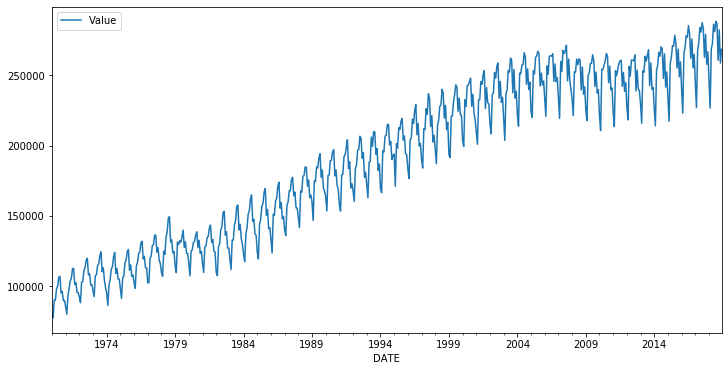

In [6]:
# Plotting the time series
df.plot(figsize=(12,6),legend=True)

### Seasonal Decomposition

In [7]:
#Performing a Seasonal Decomposition on the model and plotting the ETS components
from statsmodels.tsa.seasonal import seasonal_decompose
result=seasonal_decompose(df['Value'])

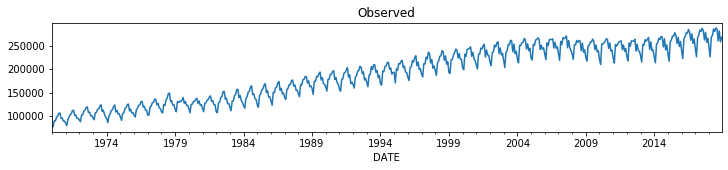

In [8]:
result.observed.plot(figsize=(12,2),title='Observed');

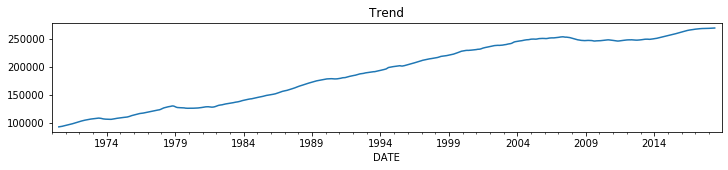

In [9]:
result.trend.plot(figsize=(12,2),title='Trend');

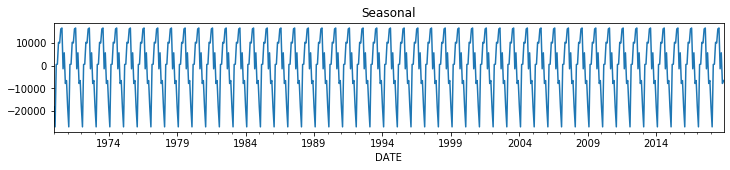

In [10]:
result.seasonal.plot(figsize=(12,2),title='Seasonal');

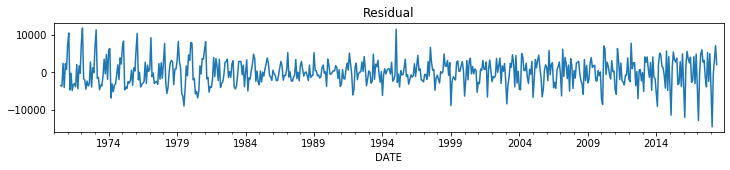

In [11]:
result.resid.plot(figsize=(12,2),title='Residual');

## Train Test Split

In [12]:
# length of the data set
len(df)

588

In [13]:
588-12

576

In [14]:
#Split the data into a train/test split where the test set is the last 12 months of data
train=df.iloc[:576]
test=df.iloc[576:]

In [15]:
len(test)

12

## Scale Data

In [16]:
# Using a MinMaxScaler to scale the train and test sets into scaled versions
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [17]:
scaled_train=scaler.transform(train)
scaled_test=scaler.transform(test)

# Time Series Generator



In [18]:
#Creating a TimeSeriesGenerator object based off the scaled_train data
from keras.preprocessing.sequence import TimeseriesGenerator

Using TensorFlow backend.


In [19]:
n_input=12
n_features=1
generator=TimeseriesGenerator(scaled_train,scaled_train,length=n_input,batch_size=1)

In [20]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [21]:
#Creating a Keras Sequential Model with  LSTM units  and a final Dense Layer
model=Sequential()
model.add(LSTM(units=150,activation='relu',input_shape=(n_input,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [23]:
# Fitting the model to the generator
model.fit_generator(generator,epochs=10)

Epoch 1/10
564/564 [==============================] - 6s 11ms/step - loss: 0.0119
Epoch 2/10
564/564 [==============================] - 5s 9ms/step - loss: 0.0056
Epoch 3/10
564/564 [==============================] - 5s 9ms/step - loss: 0.0039
Epoch 4/10
564/564 [==============================] - 5s 9ms/step - loss: 0.0028
Epoch 5/10
564/564 [==============================] - 5s 9ms/step - loss: 0.0024
Epoch 6/10
564/564 [==============================] - 5s 9ms/step - loss: 0.0015
Epoch 7/10
564/564 [==============================] - 5s 9ms/step - loss: 0.0019
Epoch 8/10
564/564 [==============================] - 5s 9ms/step - loss: 0.0014
Epoch 9/10
564/564 [==============================] - 5s 9ms/step - loss: 0.0012
Epoch 10/10
564/564 [==============================] - 5s 9ms/step - loss: 0.0012


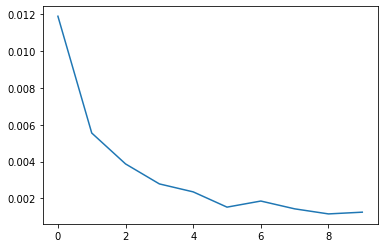

In [24]:
# Plotting the history of the loss that occured during training
loss=model.history.history['loss']
plt.plot(range(len(loss)),loss)

## Evaluation on Test Data



In [25]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # getting prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # storing prediction
    test_predictions.append(current_pred) 
    
    # updating batch to include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
test_predictions

[array([0.8057485], dtype=float32),
 array([0.7688734], dtype=float32),
 array([0.87906176], dtype=float32),
 array([0.91728044], dtype=float32),
 array([0.9538971], dtype=float32),
 array([0.9634547], dtype=float32),
 array([0.97937876], dtype=float32),
 array([0.96350807], dtype=float32),
 array([0.92033416], dtype=float32),
 array([0.9382796], dtype=float32),
 array([0.8850072], dtype=float32),
 array([0.8847033], dtype=float32)]

In [26]:
#Inverse Transforming forecasted predictions
true_pred=scaler.inverse_transform(test_predictions)
true_pred

array([[246569.42057544],
       [238829.29417652],
       [261957.94217473],
       [269980.08070493],
       [277665.95908463],
       [279672.1098876 ],
       [283014.58107358],
       [279683.30729932],
       [270621.06058699],
       [274387.83235502],
       [263205.89683825],
       [263142.10286915]])

In [27]:
test

,Value
DATE,
2018-01-01,245695.0
2018-02-01,226660.0
2018-03-01,268480.0
2018-04-01,272475.0
2018-05-01,286164.0
2018-06-01,280877.0
2018-07-01,288145.0
2018-08-01,286608.0
2018-09-01,260595.0


In [28]:
# Create a dataframe that has both the original test values and predictions
test['Predictions']=true_pred

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [29]:
test

,Value,Predictions
DATE,,
2018-01-01,245695.0,246569.420575
2018-02-01,226660.0,238829.294177
2018-03-01,268480.0,261957.942175
2018-04-01,272475.0,269980.080705
2018-05-01,286164.0,277665.959085
2018-06-01,280877.0,279672.109888
2018-07-01,288145.0,283014.581074
2018-08-01,286608.0,279683.307299
2018-09-01,260595.0,270621.060587


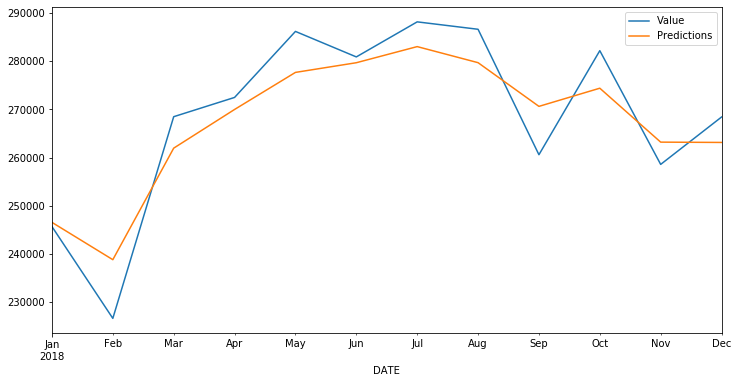

In [30]:
# Plotting out the test set against your own predicted values
test.plot(figsize=(12,6),legend=True)

# Saving Models



In [31]:
model.save('rnn')

In [32]:
from keras.models import load_model
new_model = load_model('rnn')

In [33]:
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________
